**Завдання:**

Застосуйте описані у лекції методи трансформації даних на датасеті Data_to_Transform, що міститься на GitHub в папці лекції. Цей датасет містить чотири колонки, що відповідають:

1. помірно зміщенним вправо даним (Moderate Positie Skew)
2. сильно зміщеним вправо даним (Highly Positie Skew)
3. помірно зміщеним вліво даним (Moderate Negative Skew)
4. сильно зміщеним вліво даним (Hgly Negative Skew)

Оцініть результати трансформації через квантильно-квантильні графіки.

**1. Завантаження, відображення та аналіз датасету.**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Data_to_Transform.csv')

print(f"Датасет має наступні розміри: {df.shape}\n")
print("Приклад датасету:\n")
display(df.head(10))

Датасет має наступні розміри: (10000, 4)

Приклад датасету:



,Moderate Positive Skew,Highly Positive Skew,Moderate Negative Skew,Highly Negative Skew
0,0.899990,2.895074,11.180748,9.027485
1,1.113554,2.962385,10.842938,9.009762
2,1.156830,2.966378,10.817934,9.006134
3,1.264131,3.000324,10.764570,9.000125
4,1.323914,3.012109,10.753117,8.981296
5,1.342577,3.018138,10.720679,8.977754
6,1.359727,3.026771,10.718358,8.969744
7,1.404696,3.028970,10.667741,8.962335
8,1.409988,3.045471,10.658861,8.957279
9,1.420835,3.047525,10.643465,8.950892


In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Moderate Positive Skew  10000 non-null  float64
 1   Highly Positive Skew    10000 non-null  float64
 2   Moderate Negative Skew  10000 non-null  float64
 3   Highly Negative Skew    10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB


None

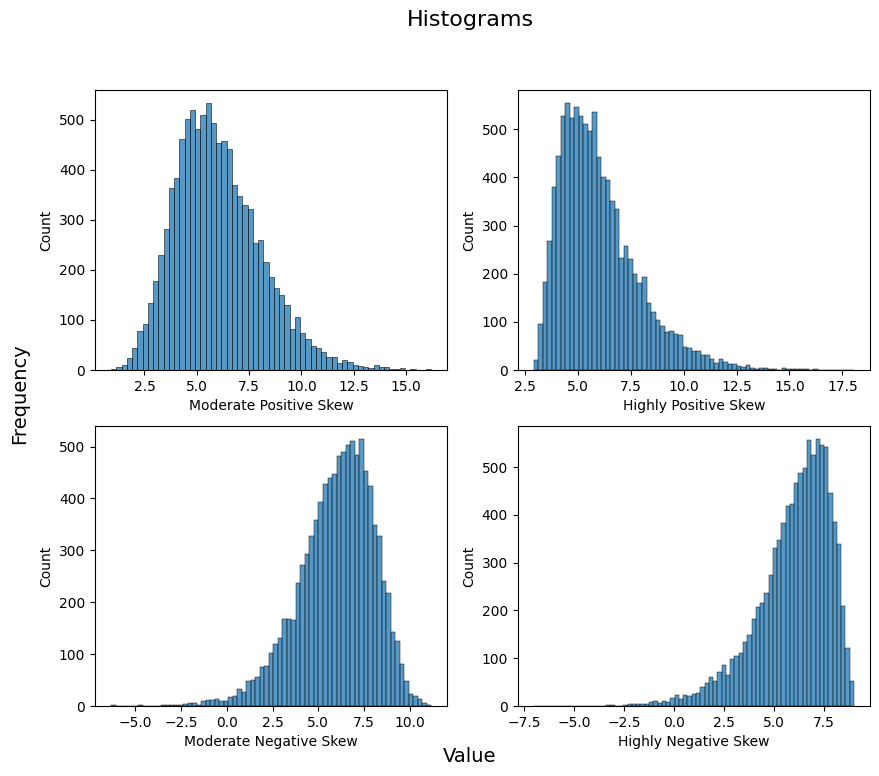

In [16]:
column = df.columns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data=df[column[0]], ax=axes[0, 0])
sns.histplot(data=df[column[1]], ax=axes[0, 1])
sns.histplot(data=df[column[2]], ax=axes[1, 0])
sns.histplot(data=df[column[3]], ax=axes[1, 1])

fig.suptitle("Histograms", fontsize=16)
fig.text(0.5, 0.04, "Value", ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

plt.show()

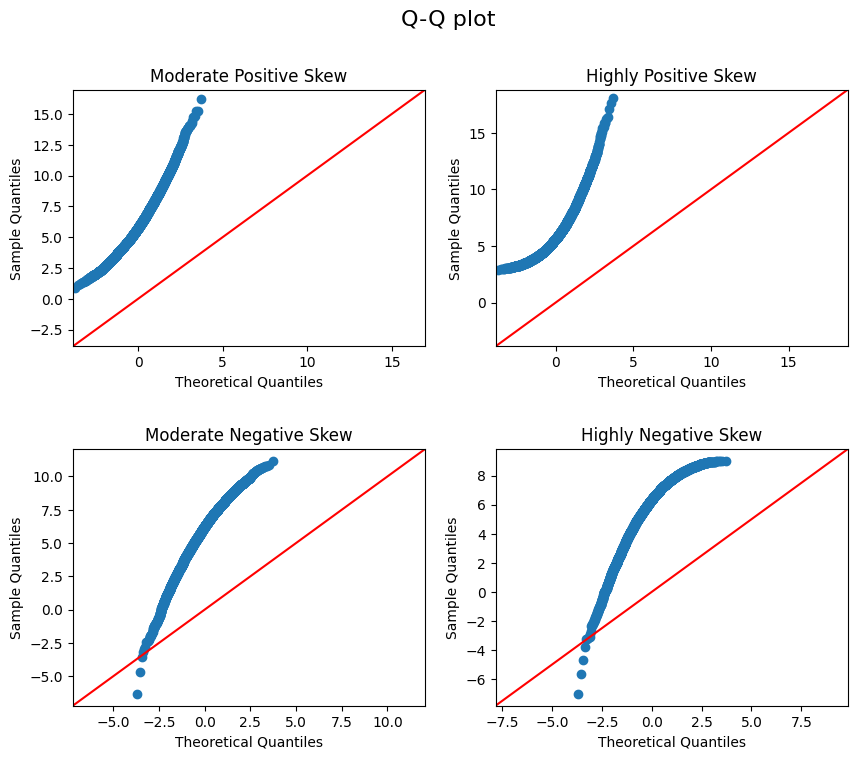

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.subplots_adjust(hspace=0.4)

sm.qqplot(data=df[column[0]], ax=axes[0, 0], line='45')
sm.qqplot(data=df[column[1]], ax=axes[0, 1], line='45')
sm.qqplot(data=df[column[2]], ax=axes[1, 0], line='45')
sm.qqplot(data=df[column[3]], ax=axes[1, 1], line='45')

axes[0, 0].set_title(column[0])
axes[0, 1].set_title(column[1])
axes[1, 0].set_title(column[2])
axes[1, 1].set_title(column[3])

fig.suptitle("Q-Q plot", fontsize=16)


plt.show()

**2. Логарифмічна трансформація даних.**

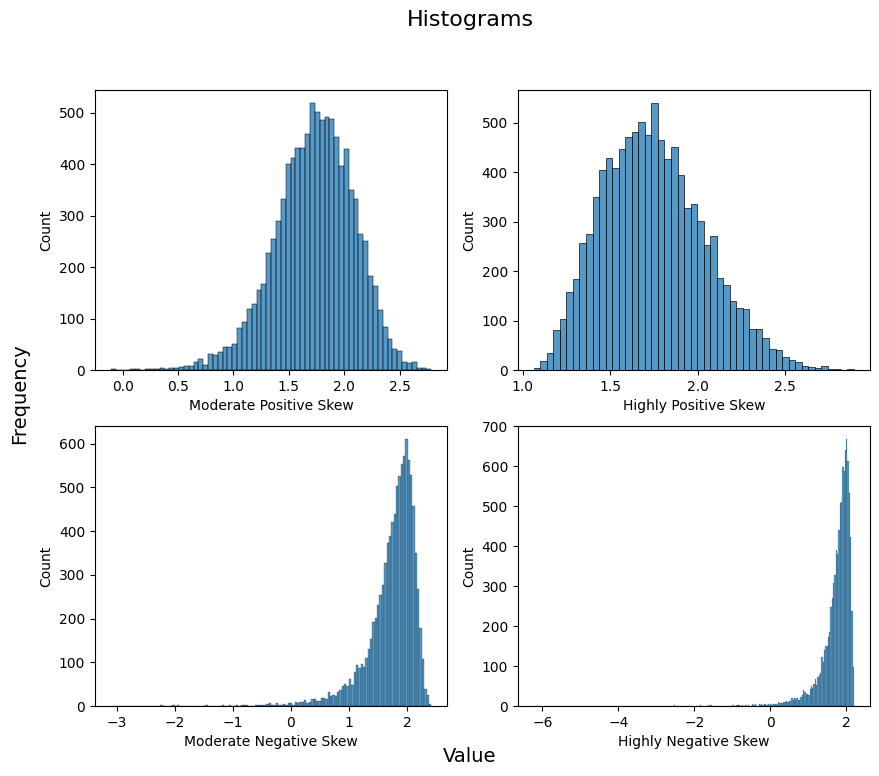

In [29]:
df_log = np.log(df)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data=df_log[column[0]], ax=axes[0, 0])
sns.histplot(data=df_log[column[1]], ax=axes[0, 1])
sns.histplot(data=df_log[column[2]], ax=axes[1, 0])
sns.histplot(data=df_log[column[3]], ax=axes[1, 1])

fig.suptitle("Histograms", fontsize=16)
fig.text(0.5, 0.04, "Value", ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

plt.show()

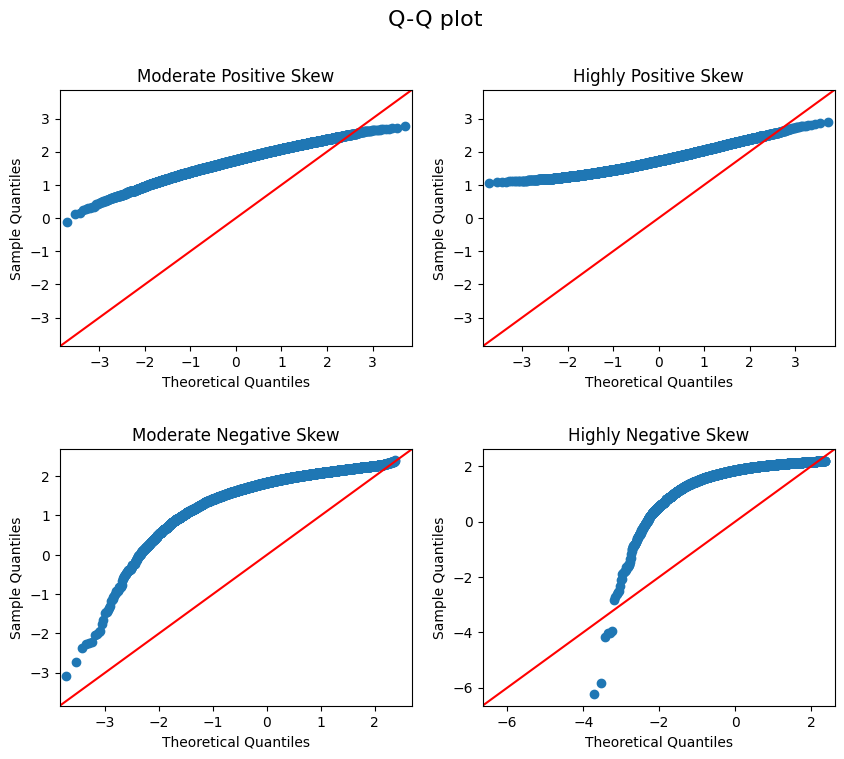

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.subplots_adjust(hspace=0.4)

sm.qqplot(data=df_log[column[0]], ax=axes[0, 0], line='45')
sm.qqplot(data=df_log[column[1]], ax=axes[0, 1], line='45')
sm.qqplot(data=df_log[column[2]], ax=axes[1, 0], line='45')
sm.qqplot(data=df_log[column[3]], ax=axes[1, 1], line='45')

axes[0, 0].set_title(column[0])
axes[0, 1].set_title(column[1])
axes[1, 0].set_title(column[2])
axes[1, 1].set_title(column[3])

fig.suptitle("Q-Q plot", fontsize=16)


plt.show()

**3. Трансформація даних кубічних корнем.**

In [31]:
df_cbrt = np.cbrt(df)

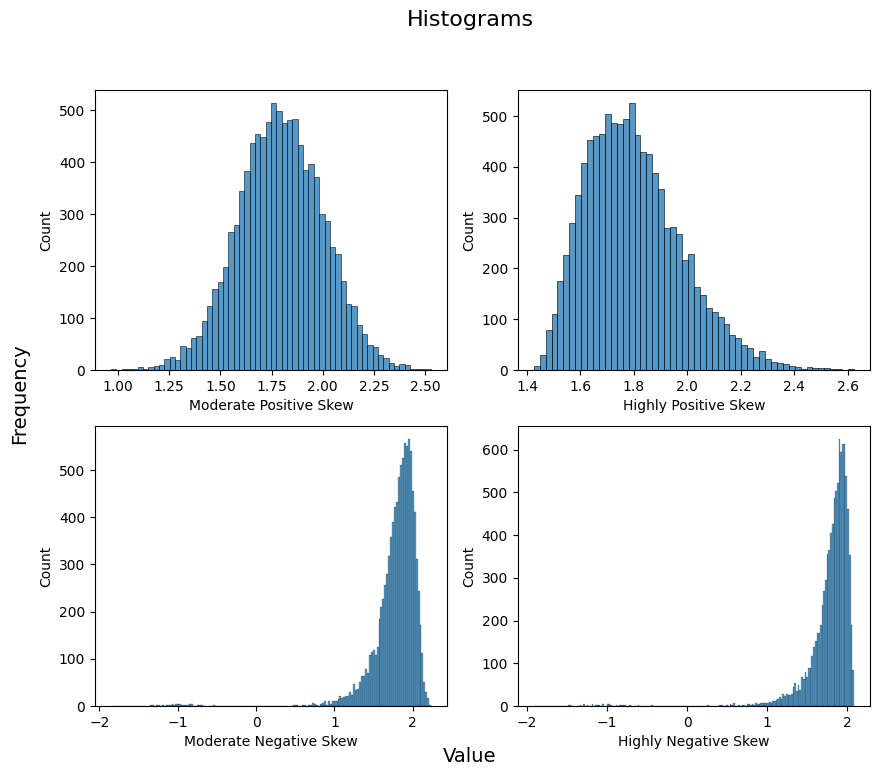

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data=df_cbrt[column[0]], ax=axes[0, 0])
sns.histplot(data=df_cbrt[column[1]], ax=axes[0, 1])
sns.histplot(data=df_cbrt[column[2]], ax=axes[1, 0])
sns.histplot(data=df_cbrt[column[3]], ax=axes[1, 1])

fig.suptitle("Histograms", fontsize=16)
fig.text(0.5, 0.04, "Value", ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

plt.show()

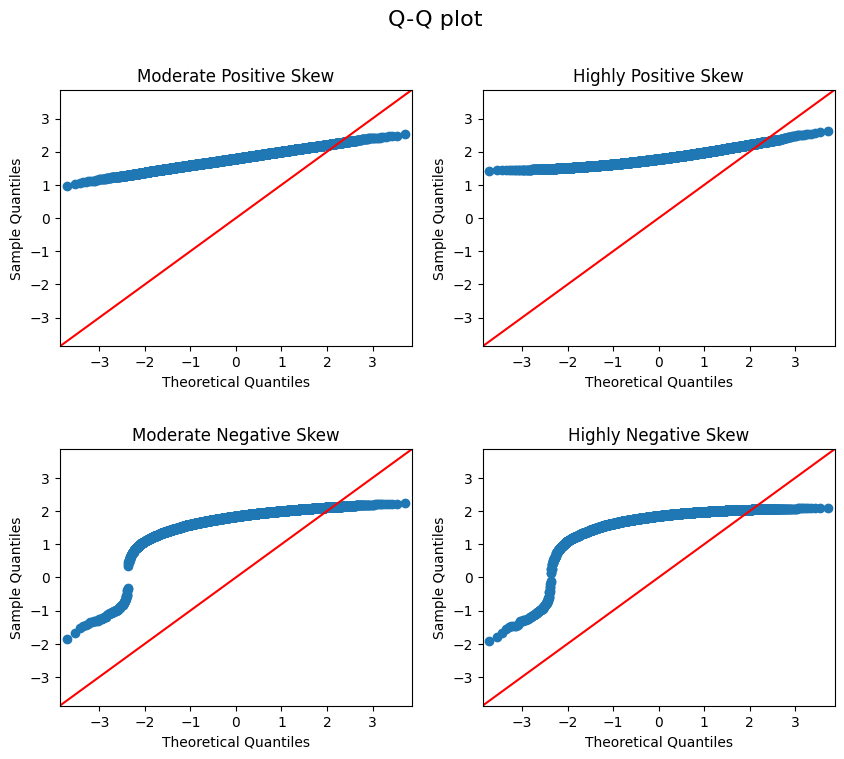

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.subplots_adjust(hspace=0.4)

sm.qqplot(data=df_cbrt[column[0]], ax=axes[0, 0], line='45')
sm.qqplot(data=df_cbrt[column[1]], ax=axes[0, 1], line='45')
sm.qqplot(data=df_cbrt[column[2]], ax=axes[1, 0], line='45')
sm.qqplot(data=df_cbrt[column[3]], ax=axes[1, 1], line='45')

axes[0, 0].set_title(column[0])
axes[0, 1].set_title(column[1])
axes[1, 0].set_title(column[2])
axes[1, 1].set_title(column[3])

fig.suptitle("Q-Q plot", fontsize=16)


plt.show()

**4. Трансформація Бокса-Кокса.**

In [57]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')

In [58]:
data_0 = df[column[0]].values.reshape(-1, 1)
data_1 = df[column[1]].values.reshape(-1, 1)    
data_2 = df[column[2]].values.reshape(-1, 1)  
data_3 = df[column[3]].values.reshape(-1, 1)  

In [59]:
transform_data_0 = pt.fit_transform(data_0)
transform_data_1 = pt.fit_transform(data_1)
transform_data_2 = yj.fit_transform(data_2)
transform_data_3 = yj.fit_transform(data_3)

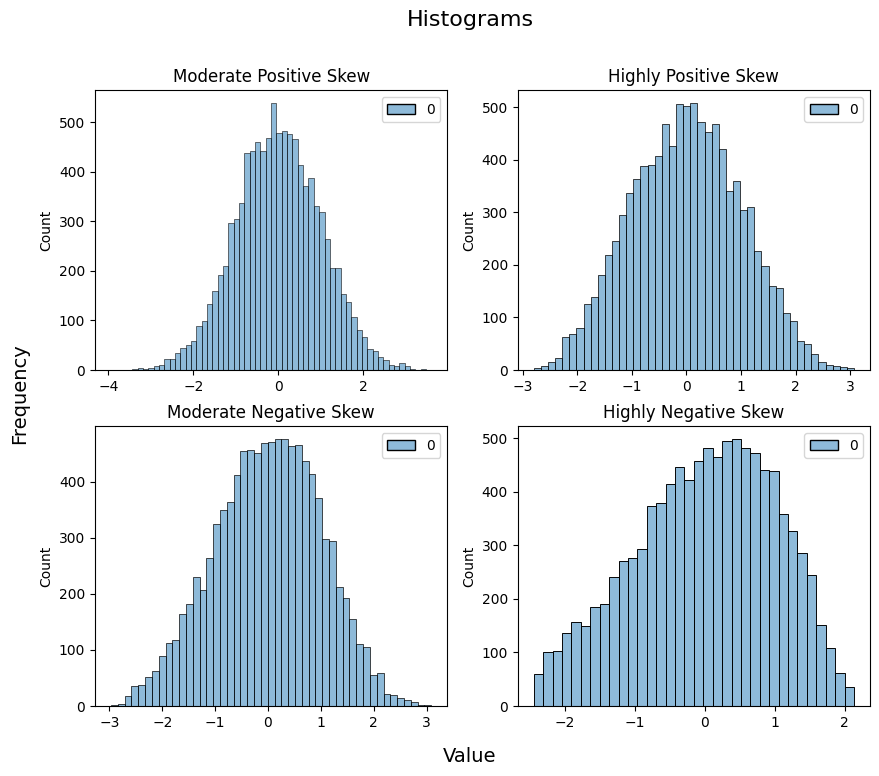

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.histplot(data=transform_data_0, ax=axes[0, 0])
sns.histplot(data=transform_data_1, ax=axes[0, 1])
sns.histplot(data=transform_data_2, ax=axes[1, 0])
sns.histplot(data=transform_data_3, ax=axes[1, 1])

axes[0, 0].set_title(column[0])
axes[0, 1].set_title(column[1])
axes[1, 0].set_title(column[2])
axes[1, 1].set_title(column[3])

fig.suptitle("Histograms", fontsize=16)
fig.text(0.5, 0.04, "Value", ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=14)

plt.show()

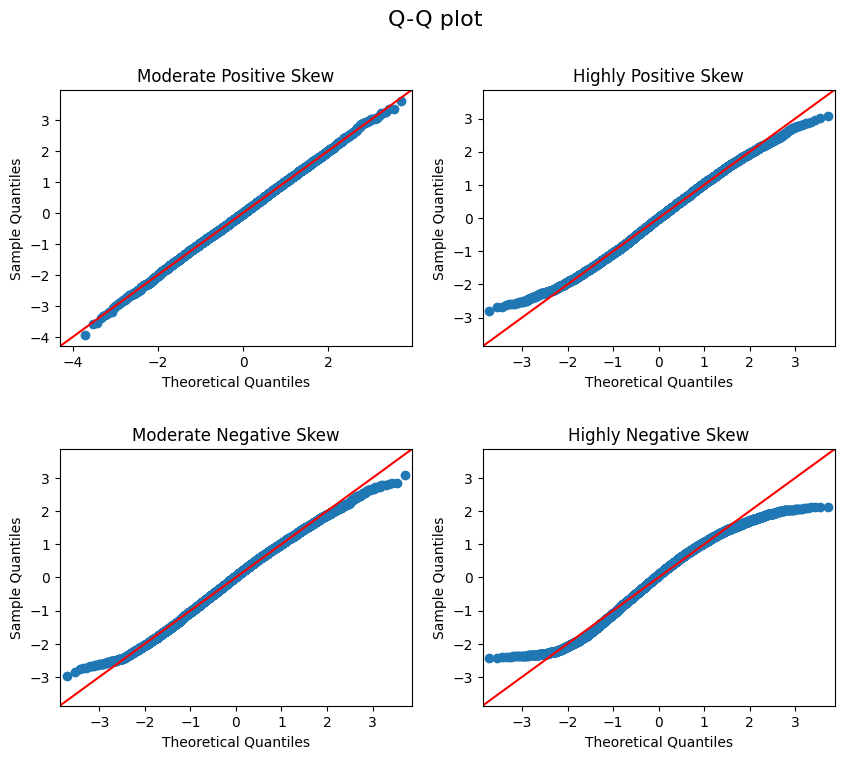

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

plt.subplots_adjust(hspace=0.4)

sm.qqplot(data=transform_data_0.ravel(), ax=axes[0, 0], line='45')
sm.qqplot(data=transform_data_1.ravel(), ax=axes[0, 1], line='45')
sm.qqplot(data=transform_data_2.ravel(), ax=axes[1, 0], line='45')
sm.qqplot(data=transform_data_3.ravel(), ax=axes[1, 1], line='45')

axes[0, 0].set_title(column[0])
axes[0, 1].set_title(column[1])
axes[1, 0].set_title(column[2])
axes[1, 1].set_title(column[3])

fig.suptitle("Q-Q plot", fontsize=16)


plt.show()